In [ ]:
#2D isothermal cylindrical SS and just SMR
'''
FOCUS ON 1D ENERGY BALANCE FOR NOW

SOME THINGS TO INVESTIGATE:
- velocity profile: do the overall conversion at each axial point (integrate at each length the overall conversion)
- BOUNDARY CONCENTRATIONS ARE LOWER THAN EXPECTED WHEN CONVERTING TO 1D
- CO2 CONC HIGHER THAN EXPECTED
- DIFFUSION
'''
from scipy.integrate import solve_bvp, solve_ivp, odeint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m
R = R_outer - R_inner

T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec
print(v0)

D1 = D2 = D3 = D4 = D5 = D6 = 8*10**-7
D = [D1, D2, D3, D4, D5, D6] #list of diffusion coefficient

Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

num_z, num_x = 10, 5 # Dimensions of the 2D domain
nz, nx = num_z, num_x+2   # Number of spatial grid points with 2 imaginary nodes
dz, dx = L / (nz - 1), R / (nx - 1)  # Spatial step sizes
z = np.linspace(0, L, nz)
x = np.linspace(0, R, nx)

u_init = np.zeros((6, len(x), len(z))).flatten() #THE NUMBER OF COMPONENTS

def pde(t,y):
    y = y.reshape((6, nx, nz)) #THE NUMBER OF COMPONENTS
    dydx2 = np.zeros_like(y)
    dydz = np.zeros_like(y)
    dydt = np.zeros_like(y)

    #MAYBE I NEED TO RESET THE BOUNDARY CONDITIONS IN HERE
    for i in range(len(D)):
        y[i,:,0] = y0[i] #i, x, z

    #no flux boundary condition 
    y[:,-1,1:] = y[:,-3,1:] #makes it so that there is no flux on top boundary (imaginary point in y)
    
    ych4 = y[0,1,1:]
    yh2o = y[1,1,1:]
    yco = y[2,1,1:]
    yco2 = y[3,1,1:]
    yh2 = y[4,1,1:]

    v = v0*(-2*y[0,1:-1,:] + 3*y0[0])/y0[0]

    rsmr = Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(ych4*yh2o-(P**2)*yco*(yh2**3)/Keqsmr)
    rwgs = Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(yh2o*yco-yco2*yh2/Keqwgs)
   
    #reaction boundary conditions.
    y[0,0,1:] = y[0,2,1:] + 2*dx/D1 * (- rsmr)
    y[1,0,1:] = y[1,2,1:] + 2*dx/D2 * (- rsmr - rwgs)
    y[2,0,1:] = y[2,2,1:] + 2*dx/D3 * (rsmr - rwgs)
    y[3,0,1:] = y[3,2,1:] + 2*dx/D4 * (rwgs)
    y[4,0,1:] = y[4,2,1:] + 2*dx/D5 * (3*rsmr + rwgs)
    y[5,0,1:] = y[5,2,1:]

    dydz[:,1:-1,1:] = (y[:,1:-1,1:] - y[:,1:-1,:-1])/dz
    dydx2[:,1:-1,:] = (y[:,2:, :] - 2 * y[:,1:-1, :] + y[:,:-2, :]) / dx**2

    for i in range(len(D)):
        dydt[i, 1:-1, :] = D[i] * dydx2[i, 1:-1, :] - v * dydz[i, 1:-1, :]

    return dydt.flatten()

t_final = 10
t_span = (0, t_final)  # Time interval
t_eval = np.linspace(0, t_final, 10)  # Time evaluation points

sol = solve_ivp(pde, t_span, u_init, method='RK45', t_eval=t_eval)

sol_plot = sol.y[:, -1].reshape((6, nx, nz)) #6 is number of components
# print(sol_plot[5,1:-1,:])

[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]
0.019712035219026


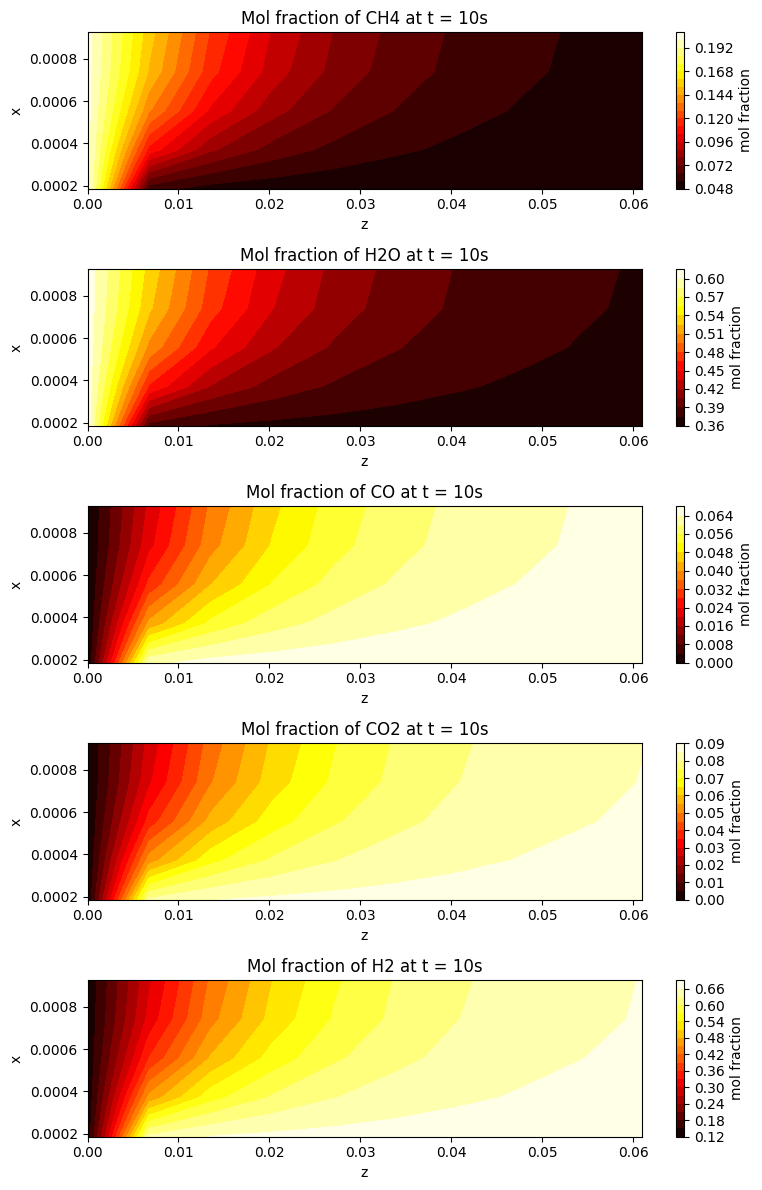

In [40]:
num_plts = 5
fig, ax = plt.subplots(num_plts, 1, figsize=(8, 12))
levels = np.linspace(0,1,100)
labels = ['CH4', 'H2O', 'CO', 'CO2', 'H2', 'Ar']
for i in range(num_plts):
    ax[i].contourf(z, x[1:-1], sol_plot[i, 1:-1, :], 20, cmap='hot')
    ax[i].set_title(f'Mol fraction of {labels[i]} at t = {sol.t[-1]:.0f}s')
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('x')
    fig.colorbar(ax[i].contourf(z, x[1:-1], sol_plot[i, 1:-1, :], 20, cmap='hot'), ax=ax[i], label='mol fraction')

plt.tight_layout()
plt.show()

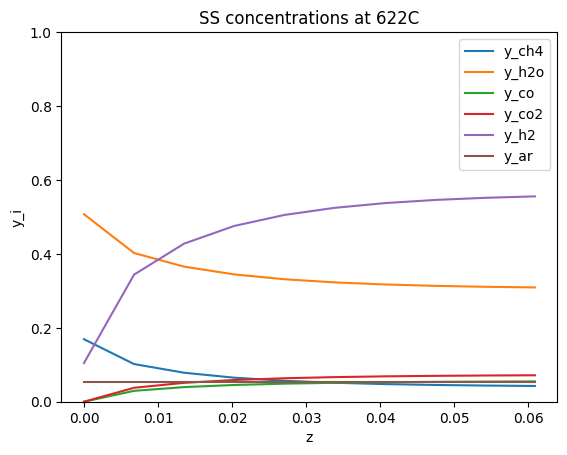

In [41]:
sol_1d = np.sum(sol_plot[:, 1:-1, :]*dx/R, axis = 1)
# print(sol_1d)
plt.plot(z, sol_1d[0], label='y_ch4')
plt.plot(z, sol_1d[1], label='y_h2o')
plt.plot(z, sol_1d[2], label='y_co')
plt.plot(z, sol_1d[3], label='y_co2')
plt.plot(z, sol_1d[4], label='y_h2')
plt.plot(z, sol_1d[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS concentrations at ' + str(T-273) + 'C')
plt.legend()

In [42]:
print(sol_1d[:,-1])
print(sum(sol_1d[:,-1]))

[0.04262228 0.30926355 0.05492474 0.07154724 0.55560072 0.05231877]
1.0862772978269264


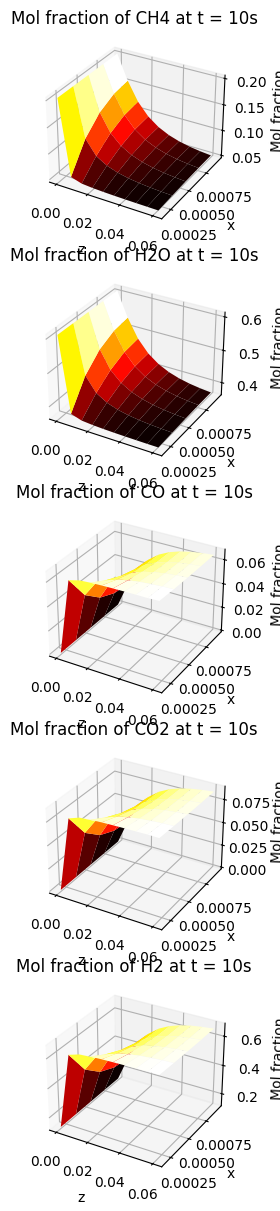

In [43]:
#plotting in 3D rough
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

num_plts = 5
fig = plt.figure(figsize=(10, 12))

labels = ['CH4', 'H2O', 'CO', 'CO2', 'H2', 'Ar']

# Create 3D axes for each plot
for i in range(num_plts):
    ax = fig.add_subplot(num_plts, 1, i + 1, projection='3d')
    
    # Create meshgrid for plotting
    Z, X = np.meshgrid(z, x[1:-1])  # Assuming z and x are 1D arrays
    
    # Plot 3D surface
    ax.plot_surface(Z, X, sol_plot[i, 1:-1, :], cmap='hot', edgecolor='none')

    # Set titles and labels
    ax.set_title(f'Mol fraction of {labels[i]} at t = {sol.t[-1]:.0f}s')
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('Mol fraction')

plt.tight_layout()
plt.show()